# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define the base URL for British Airways reviews on airlinequality.com
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

# Define a function to safely find and count all star elements within a specified HTML tag and class
def safe_find_all_stars(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return len(f_child.find_next_sibling().find_all('span', class_ = 'star fill')) if f_child else pd.NA

# Define a function to safely find and retrieve the text of the next sibling within a specified HTML tag and class
def safe_find_next_sibling(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return f_child.find_next_sibling().get_text() if f_child else pd.NA

# Define the column names for the reviews DataFrame
columns = ['name', 'header', 'time', 'text_review', 'Aircraft', 'Traveller', 'Seat_Type', 'Route',
           'Date_Flown', 'star_rating_aircraft', 'star_rating_Food', 'star_rating_Inflight', 'star_rating_Ground_Service',
           'star_rating_Wifi', 'star_rating_Value_For_Money', 'recommended']

# Define review rating category headers
review_rating_category = ['review-rating-header aircraft', 'review-rating-header type_of_traveller', 'review-rating-header cabin_flown', 
                          'review-rating-header route', 'review-rating-header date_flown']

# Define review rating stars headers
review_rating_stars = ['review-rating-header cabin_staff_service', 'review-rating-header food_and_beverages', 
                      'review-rating-header inflight_entertainment', 'review-rating-header ground_service', 
                      'review-rating-header wifi_and_connectivity', 'review-rating-header value_for_money']

# Create an empty DataFrame to store the reviews data
reviews = pd.DataFrame(columns=columns)

# Define the number of pages to scrape
pages = 10

# Define the number of reviews per page
page_size = 100


In [3]:
# Loop through each page of reviews (1 to 'pages')
for i in range(1, pages + 1):

    # Print a message indicating which page is being scraped
    print(f"Scraping page {i}")

    # Create the URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from the current page
    response = requests.get(url)

    # Parse the HTML content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Find all review body elements on the page
    bodys = parsed_content.find_all("div", {"class": "body"})

    # Iterate through each review on the current page
    for i, body in enumerate(bodys):
        row = []  # Create an empty list to store data for this review

        # Append data for various fields to the 'row' list
        row.append(body.find('span', itemprop='name').get_text())  # Extract the name
        row.append(body.find('h2', class_='text_header').get_text().replace('"', ''))  # Extract the header
        row.append(body.find('time', itemprop='datePublished').get('datetime'))  # Extract the timestamp
        row.append(body.find('div', class_='text_content').get_text())  # Extract the review text

        # Extract data for review rating categories
        for j in review_rating_category:
            row.append(safe_find_next_sibling(body, j))

        # Extract star ratings for different aspects
        for j in review_rating_stars:
            row.append(safe_find_all_stars(body, j))

        # Extract the "recommended" field
        row.append(body.find('td', class_='review-rating-header recommended').find_next_sibling('td').get_text())

        # Add the 'row' data as a new row in the 'reviews' DataFrame
        reviews.loc[len(reviews)] = row  # type: ignore


Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [4]:
reviews.head(1)

,name,header,time,text_review,Aircraft,Traveller,Seat_Type,Route,Date_Flown,star_rating_aircraft,star_rating_Food,star_rating_Inflight,star_rating_Ground_Service,star_rating_Wifi,star_rating_Value_For_Money,recommended
0,E Michaels,standards are worse than ever,2023-08-27,✅ Trip Verified | Chaos at Terminal 5 with B...,A320,Business,Business Class,London Heathrow to Malaga,August 2023,2,2,NaN,1,1,2,no


### Splitting the 'Route' Column into 'From' and 'To'

Sometimes, it's useful to split the 'Route' column into two separate columns: 'From' and 'To'. This allows for better analysis of flight routes.


In [5]:
# Split the 'Route' column into two new columns: 'From' and 'To'
split_route = reviews['Route'].str.split(' to ', expand=True)

# Insert the 'From' column after the 'Route' column (at index 7)
reviews.insert(7, 'From', split_route[0])

# Insert the 'To' column after the 'From' column (at index 8)
reviews.insert(8, 'To', split_route[1])

### Extracting Verification Status from Review Text

In some cases, it's important to know whether a review is verified or not. We can extract this information from the review text and create a new column called 'Verified' in our DataFrame.


In [7]:
# Define a function to extract the verification status from the review text
def extract_verification(text):
    if '✅ Trip Verified | ' in text:
        return 1, text.replace('✅ Trip Verified | ', '')  # Return 1 for verified and remove the prefix
    elif 'Not Verified | ' in text:
        return 0, text.replace('Not Verified | ', '')  # Return 0 for not verified and remove the prefix
    else:
        return None, text  # Return None if verification status is not found

# Apply the 'extract_verification' function to create a new 'Verified' column
reviews.insert(3, 'Verified', reviews['text_review'].apply(lambda x: extract_verification(x)[0]))

# Update the 'text_reviow' column with the cleaned review text
reviews['text_reviow'] = reviews['text_review'].apply(lambda x: extract_verification(x)[1])

In [8]:
reviews['recommended'] = reviews['recommended'].replace({'yes': 1, 'no': 0})

#### Foremating date flown

In [9]:
reviews['Date_Flown'] = pd.to_datetime(reviews['Date_Flown'], format='%B %Y')

In [10]:
reviews.head()

,name,header,time,Verified,text_review,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_rating_aircraft,star_rating_Food,star_rating_Inflight,star_rating_Ground_Service,star_rating_Wifi,star_rating_Value_For_Money,recommended,text_reviow
0,E Michaels,standards are worse than ever,2023-08-27,NaN,✅ Trip Verified | Chaos at Terminal 5 with B...,A320,Business,Business Class,London Heathrow,Malaga,London Heathrow to Malaga,2023-08-01,2,2,NaN,1,1,2,0,✅ Trip Verified | Chaos at Terminal 5 with B...
1,M Morris,still waiting for reimbursement,2023-08-27,0.0,Not Verified | BA cancelled our flight and co...,NaN,Couple Leisure,Economy Class,Newark,London,Newark to London,2023-06-01,<NA>,<NA>,NaN,<NA>,<NA>,1,0,BA cancelled our flight and could not book us...
2,G Graham,"unprofessional, uncaring",2023-08-27,1.0,✅ Trip Verified | When on our way to Heathrow ...,NaN,Business,Business Class,London,Johannesburg,London to Johannesburg,2023-08-01,2,NaN,NaN,2,NaN,1,0,When on our way to Heathrow Airport and merely...
3,W Davies,"Nice flight, good crew, very good seat",2023-08-26,1.0,"✅ Trip Verified | Nice flight, good crew, very...",Boeing 777-300,Couple Leisure,Business Class,LHR,LAX,LHR to LAX,2023-08-01,5,3,5,5,NaN,4,1,"Nice flight, good crew, very good seat, food w..."
4,K Nuram,Such a horrible experience,2023-08-26,1.0,✅ Trip Verified | 8 months have passed and st...,NaN,Family Leisure,Economy Class,Delhi,Vancouver via London,Delhi to Vancouver via London,2022-12-01,1,NaN,NaN,1,NaN,1,0,8 months have passed and still wasting my tim...


### Filling Missing Star Ratings with Row Means

There are missing values (NaN) in the star rating columns for various aspects of the reviews. To handle this, we can fill these missing values with the mean value of the respective row.

In [24]:
# Define the columns containing star ratings
stars_columns = reviews.columns[list(range(12, 18))]

# Print the columns with star ratings
print(stars_columns)

# Define a function to fill NaN values with the row mean
def fill_nan_with_row_mean(row):
    return row.fillna(row.mean())

# Apply the 'fill_nan_with_row_mean' function to each row in the star rating columns
reviews[stars_columns] = reviews[stars_columns].apply(fill_nan_with_row_mean, axis=1)


Index(['star_rating_aircraft', 'star_rating_Food', 'star_rating_Inflight',
       'star_rating_Ground_Service', 'star_rating_Wifi',
       'star_rating_Value_For_Money'],
      dtype='object')


### Chacking noumbers of route present in the data

In [25]:
reviews['Route'].nunique()

652

Note: found 652 out of 1000 so the mostly all the Route is unique

### Analyzing Review Recommendations and Verified Trips

Let's perform some analysis on the recommendations made in the reviews, considering both verified and not verified trips.

In [26]:
# Print the total number of recommendations (recommending and not recommending)
print('Total Number of Recommending and Not Recommending Reviews:')
print(reviews.recommended.value_counts())

# Print the total number of recommendations (recommending and not recommending) for verified trips only
print('\nTotal Number of Recommending and Not Recommending Reviews for Verified Trips:')
print(reviews.loc[reviews['Verified'] == 1, 'recommended'].value_counts())

# Print the total number of recommendations (recommending and not recommending) for not verified trips only
print('\nTotal Number of Recommending and Not Recommending Reviews for Not Verified Trips:')
print(reviews.loc[reviews['Verified'] == 0, 'recommended'].value_counts())

# If you want to calculate the mean star ratings for each recommendation category, you can uncomment the following line:
# reviews.groupby('recommended')[stars_columns].mean()


Total Number of Recommending and Not Recommending Reviews:
recommended
0    655
1    345
Name: count, dtype: int64

Total Number of Recommending and Not Recommending Reviews for Verified Trips:
recommended
0    503
1    289
Name: count, dtype: int64

Total Number of Recommending and Not Recommending Reviews for Not Verified Trips:
recommended
0    149
1     53
Name: count, dtype: int64


### Calculating Mean Star Ratings

Let's calculate and compare the mean star ratings for reviews, considering verified and not verified trips, as well as an overall mean.

In [27]:
# Calculate the mean star ratings for verified trips
mean_of_stars_verified = reviews.loc[reviews['Verified'] == 1, stars_columns].mean()

# Calculate the mean star ratings for not verified trips
mean_of_stars_not_verified = reviews.loc[reviews['Verified'] == 0, stars_columns].mean()

# Calculate the overall mean star ratings for all reviews
mean_of_stars = reviews.loc[:, stars_columns].mean()

# Print the mean star ratings for verified trips
print('------------ Mean of Stars for Verified Trips ------------\n', mean_of_stars_verified, 

# Print the mean star ratings for not verified trips
'\n------------ Mean of Stars for Not Verified Trips ------------\n', mean_of_stars_not_verified, 

# Print the overall mean star ratings for all reviews
'\n------------ Overall Mean of Stars ------------\n', mean_of_stars)


------------ Mean of Stars for Verified Trips ------------
 star_rating_aircraft           3.034722
star_rating_Food               2.516898
star_rating_Inflight           2.594928
star_rating_Ground_Service     2.650253
star_rating_Wifi               2.526052
star_rating_Value_For_Money    2.484848
dtype: float64 
------------ Mean of Stars for Not Verified Trips ------------
 star_rating_aircraft           2.975248
star_rating_Food               2.404290
star_rating_Inflight           2.480281
star_rating_Ground_Service     2.356436
star_rating_Wifi               2.286221
star_rating_Value_For_Money    2.257426
dtype: float64 
------------ Overall Mean of Stars ------------
 star_rating_aircraft           3.02650
star_rating_Food               2.50005
star_rating_Inflight           2.57480
star_rating_Ground_Service     2.59100
star_rating_Wifi               2.47645
star_rating_Value_For_Money    2.44300
dtype: float64


- There batter review from the people not verified then people are, also over all the reviews are avarige.
- My main speculation is to deside if a review is good or bad we can use if Airways is recommended or not.

In [28]:
reviews['Date_Flown'].nunique()

65

In [29]:
reviews.head()

,name,header,time,Verified,text_review,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_rating_aircraft,star_rating_Food,star_rating_Inflight,star_rating_Ground_Service,star_rating_Wifi,star_rating_Value_For_Money,recommended,text_reviow
0,E Michaels,standards are worse than ever,2023-08-27,NaN,✅ Trip Verified | Chaos at Terminal 5 with B...,A320,Business,Business Class,London Heathrow,Malaga,London Heathrow to Malaga,2023-08-01,2.0,2.000000,1.600000,1.0,1.000000,2.0,0,✅ Trip Verified | Chaos at Terminal 5 with B...
1,M Morris,still waiting for reimbursement,2023-08-27,0.0,Not Verified | BA cancelled our flight and co...,NaN,Couple Leisure,Economy Class,Newark,London,Newark to London,2023-06-01,1.0,1.000000,1.000000,1.0,1.000000,1.0,0,BA cancelled our flight and could not book us...
2,G Graham,"unprofessional, uncaring",2023-08-27,1.0,✅ Trip Verified | When on our way to Heathrow ...,NaN,Business,Business Class,London,Johannesburg,London to Johannesburg,2023-08-01,2.0,1.666667,1.666667,2.0,1.666667,1.0,0,When on our way to Heathrow Airport and merely...
3,W Davies,"Nice flight, good crew, very good seat",2023-08-26,1.0,"✅ Trip Verified | Nice flight, good crew, very...",Boeing 777-300,Couple Leisure,Business Class,LHR,LAX,LHR to LAX,2023-08-01,5.0,3.000000,5.000000,5.0,4.400000,4.0,1,"Nice flight, good crew, very good seat, food w..."
4,K Nuram,Such a horrible experience,2023-08-26,1.0,✅ Trip Verified | 8 months have passed and st...,NaN,Family Leisure,Economy Class,Delhi,Vancouver via London,Delhi to Vancouver via London,2022-12-01,1.0,1.000000,1.000000,1.0,1.000000,1.0,0,8 months have passed and still wasting my tim...


### Analyzing Mean Recommendations and Star Ratings by Date Flown

Let's analyze the mean recommendations and mean star ratings based on the date the flight was taken.

In [34]:
# Calculate the mean recommendations (1 for recommending and 0 for not recommending) by date flown
mean_reviews_on_date_flown = reviews.groupby('Date_Flown')['recommended'].mean()

# Calculate the mean star ratings by date flown
mean_stars_on_date_flown = reviews.groupby('Date_Flown')[stars_columns].mean()

# Display the mean star ratings by date flown
mean_stars_on_date_flown


,star_rating_aircraft,star_rating_Food,star_rating_Inflight,star_rating_Ground_Service,star_rating_Wifi,star_rating_Value_For_Money
Date_Flown,,,,,,
2018-02-01,5.000000,4.000000,4.000000,2.000000,4.000000,5.000000
2018-03-01,4.000000,3.500000,4.000000,4.500000,4.100000,4.500000
2018-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-06-01,3.500000,3.000000,3.500000,3.500000,3.000000,2.000000
2018-07-01,2.000000,1.333333,1.333333,1.000000,1.333333,1.000000
...,...,...,...,...,...,...
2023-04-01,2.636364,2.318182,2.788636,2.318182,2.106818,2.000000
2023-05-01,2.347826,2.113043,2.169565,1.739130,1.760870,1.521739
2023-06-01,2.580645,2.000000,2.104839,1.677419,1.840323,1.645161


### Visualizing Mean Star Ratings Over Time

Let's create a line plot to visualize the mean star ratings over time, with each aspect represented by a separate line.

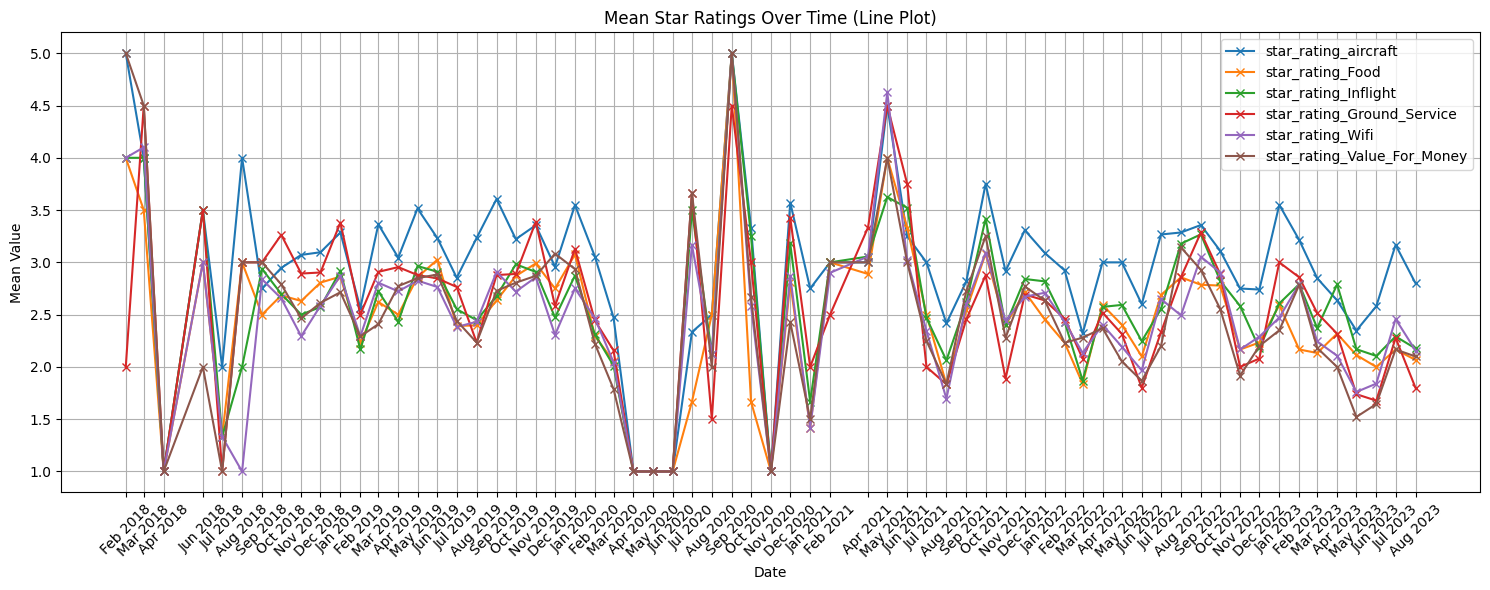

In [41]:
mean_star_ration = plt

# Create a figure for the plot with a specified figsize
mean_star_ration.figure(figsize=(15, 6))

# Iterate through each star rating column and plot it as a line
for column_name in mean_stars_on_date_flown.columns:
    mean_star_ration.plot(mean_stars_on_date_flown.index, mean_stars_on_date_flown[column_name], '-x', label=column_name)


mean_star_ration.xlabel('Date')
mean_star_ration.ylabel('Mean Value')
mean_star_ration.title('Mean Star Ratings Over Time (Line Plot)')
mean_star_ration.legend()
mean_star_ration.grid(True)
mean_star_ration.xticks(mean_stars_on_date_flown.index, mean_stars_on_date_flown.index.strftime('%b %Y'), rotation=45)

# Ensure the plot layout is tight
mean_star_ration.tight_layout()

### Visualizing the Number of Reviews per Month

Let's create a line plot to visualize the number of reviews posted per month.

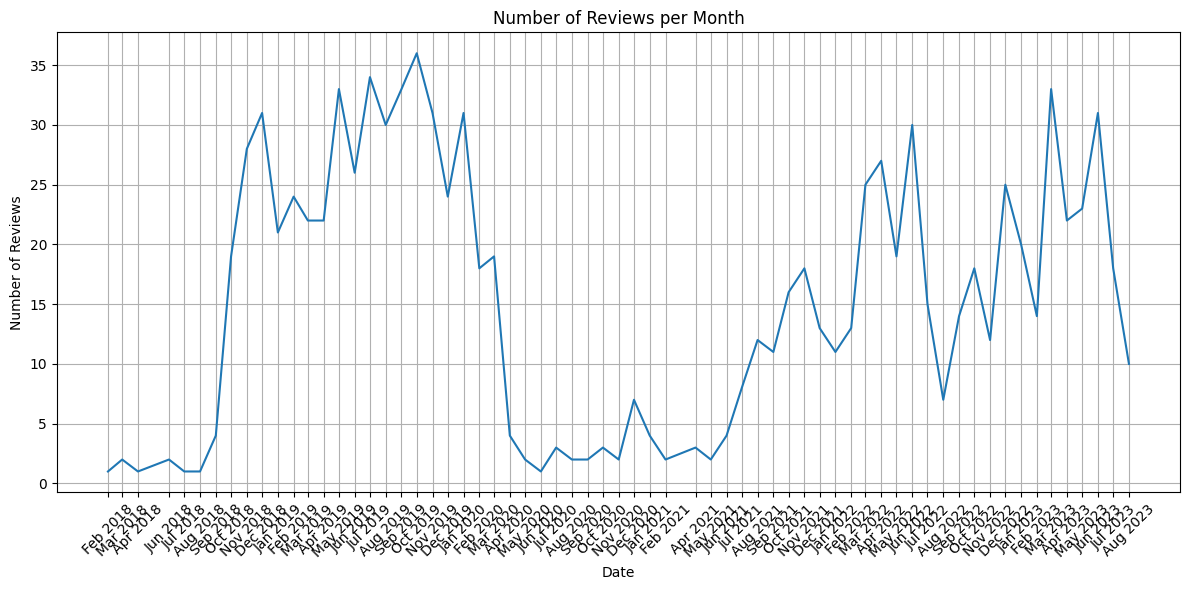

In [44]:
ploting_no_reviews_mounth = plt

# Create a figure for the plot with a specified figsize
ploting_no_reviews_mounth.figure(figsize=(12, 6))

# Calculate the number of reviews posted per month
reviews_count_per_month = reviews.groupby('Date_Flown')['name'].count()

# Plot the number of reviews per month
ploting_no_reviews_mounth.plot(reviews_count_per_month.index, reviews_count_per_month, '')

ploting_no_reviews_mounth.xlabel('Date')
ploting_no_reviews_mounth.ylabel('Number of Reviews')
ploting_no_reviews_mounth.title('Number of Reviews per Month')
ploting_no_reviews_mounth.grid(True)

# Set the x-axis ticks and labels to be in the format 'Month Year'
ploting_no_reviews_mounth.xticks(reviews_count_per_month.index, reviews_count_per_month.index.strftime('%b %Y'), rotation=45) # type: ignore

# Ensure the plot layout is tight
ploting_no_reviews_mounth.tight_layout()

# Show the plot
ploting_no_reviews_mounth.show()

Number of reviews have are low at Mar 2020 to may 2021, resine is the pandemic situation over the world.

In [43]:
reviews.shape

(1000, 20)

In [ ]:
reviews.to_csv("data/BA_reviews.csv")